In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [30]:
bool_saved = True

In [31]:
tani_thr_RefExp_max = 0.85
tani_thr_RefExp_min = 0.25
tani_thr_RefGen_max = 0.85
tani_thr_RefGen_min = 0.25
LogP_thr_min=3

number_smiles_per_msg = 10

## Load results

In [32]:
folderName_results = "../s2_runfSepaMolGen/results_AmEu/"
folderName2_results = "results202505261319_GPT4_1_SMILES10x10" # Change folder name
folderPath_results = os.path.join(folderName_results, folderName2_results)

In [33]:
fileName_genSMILESeval = "genSMILESeval.xlsx"
filePath_genSMILESeval = os.path.join(folderPath_results, fileName_genSMILESeval)
df_genSMILESeval = pd.read_excel(filePath_genSMILESeval)
print(df_genSMILESeval.shape)
df_genSMILESeval.head(1)

(100, 7)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP
0,CC(C)CCN(CC(C)C)C(=O)c1nc(NCCNC(=O)N(CC(C)C)CC...,ORGANIC,AQUEOUS,LLM generated,LOW,NaN,ORGANIC


In [34]:
number_iter = int(df_genSMILESeval.shape[0] / number_smiles_per_msg)
print("Number of iterations: ", number_iter)

Number of iterations:  10


In [35]:
# Create folder to save procssed results
folderName_saved = "results_AmEu_proc/"
folderPath_saved = os.path.join(folderName_saved, folderName2_results)
if bool_saved:
    os.makedirs(folderPath_saved, exist_ok=True)

## Log P vs Iteration

In [36]:
def calc_logP(smiles):
    m = rdkit.Chem.MolFromSmiles(smiles)
    if m:
        logP = rdMolDescriptors.CalcCrippenDescriptors(m)[0]
    else:
        logP = np.nan
    return logP

df_genSMILESeval['LogP_value'] = df_genSMILESeval['Gen_SMILES'].apply(calc_logP)
print(df_genSMILESeval.shape)
df_genSMILESeval.head(2)

(100, 8)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value
0,CC(C)CCN(CC(C)C)C(=O)c1nc(NCCNC(=O)N(CC(C)C)CC...,ORGANIC,AQUEOUS,LLM generated,LOW,NaN,ORGANIC,5.2352
1,CCCCCCCCN(CCNC(=O)N(CCCCCCCC)CCCCCCCC)C(=O)NCC...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,12.8237


In [37]:
arr2D_logP = np.array(df_genSMILESeval['LogP_value']).reshape(number_iter, number_smiles_per_msg)
df_iter_logP = pd.DataFrame(arr2D_logP, columns=[f'SMILES{i}' for i in range(number_iter)])
df_iter_logP.index.name = 'Iteration'
df_iter_logP

,SMILES0,SMILES1,SMILES2,SMILES3,SMILES4,SMILES5,SMILES6,SMILES7,SMILES8,SMILES9
Iteration,,,,,,,,,,
0,5.23520,12.8237,6.61110,2.82480,5.37180,11.66310,1.94880,4.67100,15.89660,12.12290
1,12.47430,4.3419,10.98140,4.33730,1.30510,5.17620,3.17780,NaN,5.88960,11.86910
2,4.81940,12.1229,5.44120,3.18110,4.26910,3.63650,3.32290,14.38340,2.16200,7.72090
3,-0.06670,0.7539,3.50644,5.35030,0.71700,0.90237,1.05484,6.83784,1.06634,4.46277
4,9.50034,5.4412,12.73960,2.95417,5.47680,7.79584,5.44120,4.08684,NaN,4.89850
5,NaN,7.1201,1.56020,2.52117,7.49100,0.68987,2.78694,3.51677,5.51120,5.50147
6,10.40050,4.4954,13.26780,1.54597,2.66277,8.19180,8.49497,6.04380,4.08684,8.55550
7,NaN,10.9853,4.77360,8.21960,9.02540,11.43560,10.45090,3.96010,NaN,6.47940
8,13.35350,NaN,6.40650,13.76690,3.75690,5.52070,10.02550,NaN,5.33140,14.14540


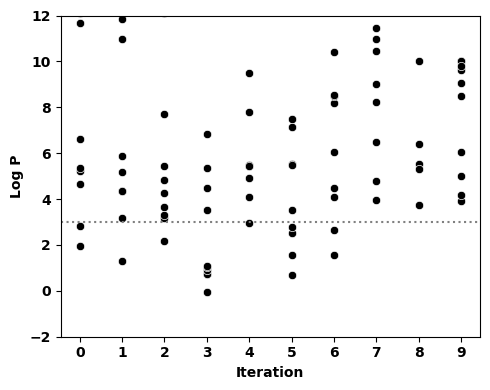

In [38]:
plt.figure(figsize=(5, 4))
for i in range(number_iter):
    sns.scatterplot(
        data=df_iter_logP,
        x=df_iter_logP.index,
        y=df_iter_logP[f'SMILES{i}'],
        label=f'SMILES{i}',
        color='black',
        legend=False
    )
plt.axhline(y=LogP_thr_min, color='grey', linestyle=':')

plt.xlabel('Iteration', fontsize=10, fontweight='bold')
plt.ylabel('Log P', fontsize=10, fontweight='bold')
plt.xticks([i for i in range(number_iter)], fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
# plt.legend()
plt.ylim(-2, 12)

if bool_saved:
    imagePath_logP = os.path.join(folderPath_saved, "logP_iter.png")
    plt.savefig(imagePath_logP, bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

## Max Similarity vs Iteration

In [11]:
def calc_max_similarity(one_smiles, all_smiles):
    list_similarity = []
    max_similarity_score = 0

    m1 = rdkit.Chem.MolFromSmiles(one_smiles)
    if m1:
        fp1 = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(m1, 4, nBits=2048)
        for one_smiles_ref in all_smiles:
            m2 = rdkit.Chem.MolFromSmiles(one_smiles_ref)
            if m2:
                fp2 = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(m2, 4, nBits=2048)
                similarity = rdkit.DataStructs.TanimotoSimilarity(fp1, fp2)
                list_similarity.append(similarity)
            else:
                similarity = np.nan
                list_similarity.append(similarity)
        max_similarity_score = max(list_similarity)
    else:
        max_similarity_score = np.nan

    return max_similarity_score

In [12]:
# Load all exp SMILES
filePath_all_ExpSMILES = '../s0_prepData/s0f_analyzeData_LnAn/output_uniqueSMILES_ClassBySMARTS.xlsx'
list_all_ExpSMILES = list(pd.read_excel(filePath_all_ExpSMILES)['SMILES'])
print(len(list_all_ExpSMILES))
print(list_all_ExpSMILES[0:1])

295
['CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@H](C)C(=O)N(CCCCCCCC)CCCCCCCC']


### Max Sim to Exp

In [13]:
df_genSMILESeval['MaxSim_ToExp_value'] = df_genSMILESeval['Gen_SMILES'].apply(
    lambda x: calc_max_similarity(x, list_all_ExpSMILES)
)
print(df_genSMILESeval.shape)
df_genSMILESeval.head(2)

(100, 9)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253


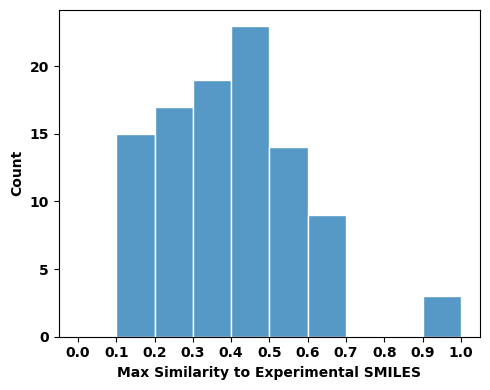

In [14]:
bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(5, 4))
sns.histplot(data=df_genSMILESeval, x='MaxSim_ToExp_value', bins=bins, edgecolor='white')

plt.xlabel('Max Similarity to Experimental SMILES', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.xticks(bins, fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

if bool_saved:
    imagePath_MaxSim_toExp_hist = os.path.join(folderPath_saved, "MaxSim_toExp_hist.png")
    plt.savefig(imagePath_MaxSim_toExp_hist, bbox_inches='tight', dpi=300)
    
plt.tight_layout()
plt.show()

In [15]:
arr2D_MaxSim_ToExp = np.array(df_genSMILESeval['MaxSim_ToExp_value']).reshape(number_iter, number_smiles_per_msg)
df_iter_MaxSimToExp = pd.DataFrame(arr2D_MaxSim_ToExp, columns=[f'SMILES{i}' for i in range(number_iter)])
df_iter_MaxSimToExp.index.name = 'Iteration'
df_iter_MaxSimToExp

,SMILES0,SMILES1,SMILES2,SMILES3,SMILES4,SMILES5,SMILES6,SMILES7,SMILES8,SMILES9
Iteration,,,,,,,,,,
0,0.666667,0.313253,0.450549,0.111111,1.000000,0.558442,0.198113,0.316327,0.441558,0.142857
1,0.590909,0.296703,0.367925,0.273504,0.300000,0.173228,0.535211,0.297521,0.344262,0.198529
2,0.606742,0.622222,0.530864,0.610526,0.129032,0.541667,0.457143,0.407895,0.589744,0.317647
3,0.500000,0.246914,0.558140,0.520548,0.232759,0.575342,0.150794,0.410526,0.474359,0.911111
4,0.629213,0.317647,0.558140,0.484536,0.150794,0.166667,0.610526,0.309859,0.520548,0.280000
5,0.121053,0.452830,0.477876,0.338235,0.257143,0.486486,0.406977,0.282051,0.948052,0.392000
6,0.443299,0.341772,0.452381,0.373737,0.413043,0.233766,0.380165,0.127451,0.380282,0.484211
7,0.697917,0.266667,0.666667,0.150000,0.435185,0.345794,0.380952,0.389474,0.142857,0.559140
8,0.552632,0.300000,0.416667,0.410526,0.261905,0.292035,0.459184,0.611111,0.152318,0.272727


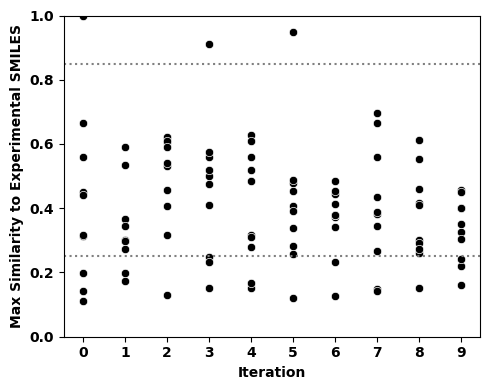

In [16]:
plt.figure(figsize=(5, 4))
for i in range(number_iter):
    sns.scatterplot(
        data=df_iter_MaxSimToExp,
        x=df_iter_MaxSimToExp.index,
        y=df_iter_MaxSimToExp[f'SMILES{i}'],
        label=f'SMILES{i}',
        color='black',
        legend=False
    )
plt.axhline(y=tani_thr_RefExp_min, color='grey', linestyle=':')
plt.axhline(y=tani_thr_RefExp_max, color='grey', linestyle=':')

plt.xlabel('Iteration', fontsize=10, fontweight='bold')
plt.ylabel('Max Similarity to Experimental SMILES', fontsize=10, fontweight='bold')
plt.xticks([i for i in range(number_iter)], fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.ylim(0, 1)
# plt.legend()

if bool_saved:
    imagePath_MaxSimToExp = os.path.join(folderPath_saved, "MaxSim_ToExp.png")
    plt.savefig(imagePath_MaxSimToExp, bbox_inches='tight', dpi=300)
    
plt.tight_layout()
plt.show()

### Max Sim to Prev Generated

In [86]:
list_MaxSim_ToPrevGen = []
list_genSMILES_addIter = []
list_all_genSMILES = list(df_genSMILESeval['Gen_SMILES'])

for i, one_genSMILES in enumerate(list_all_genSMILES):
    if i+1 > number_smiles_per_msg:
        m1 = rdkit.Chem.MolFromSmiles(one_genSMILES)
        if m1:
            fp1 = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(m1, 4, nBits=2048)
            max_similarity_score = calc_max_similarity(one_genSMILES, list_genSMILES_addIter)
            list_MaxSim_ToPrevGen.append(max_similarity_score)
        else:
            list_MaxSim_ToPrevGen.append(np.nan)
    else:
        list_MaxSim_ToPrevGen.append(np.nan)
    
    if ((i+1)%number_smiles_per_msg==0):
        list_genSMILES_addIter = list_genSMILES_addIter + list(df_genSMILESeval['Gen_SMILES'][(i+1-number_smiles_per_msg):(i+1)])

df_genSMILESeval['MaxSim_ToPrevGen_value'] = pd.DataFrame(list_MaxSim_ToPrevGen)
print(df_genSMILESeval.shape)
df_genSMILESeval.head(2)

(100, 10)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN


In [87]:
arr2D_MaxSim_ToPrevGen = np.array(df_genSMILESeval['MaxSim_ToPrevGen_value']).reshape(number_iter, number_smiles_per_msg)
df_iter_MaxSimToPrevGen = pd.DataFrame(arr2D_MaxSim_ToPrevGen, columns=[f'SMILES{i}' for i in range(number_iter)])
df_iter_MaxSimToPrevGen.index.name = 'Iteration'
df_iter_MaxSimToPrevGen

,SMILES0,SMILES1,SMILES2,SMILES3,SMILES4,SMILES5,SMILES6,SMILES7,SMILES8,SMILES9
Iteration,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.524272,0.222222,0.218750,0.238462,0.347826,0.173228,0.311927,0.169935,0.178808,0.194805
2,0.470588,0.575758,0.345794,0.428571,0.460526,0.370000,0.369231,0.216981,0.398058,0.416667
3,0.419048,0.261905,0.525253,0.662651,0.333333,0.425926,0.277778,0.438095,0.397849,0.506667
4,0.684783,0.744681,1.000000,0.421053,1.000000,0.182432,1.000000,0.301370,1.000000,0.255172
5,0.415584,0.554217,0.584746,0.336957,0.657658,0.487179,0.330357,0.341880,0.578431,0.495868
6,0.387931,0.504762,0.572816,0.382609,0.401869,0.493333,0.385827,0.609195,0.424242,0.449153
7,0.666667,0.330000,0.447917,0.688312,0.427273,0.634783,0.358696,0.297710,0.698630,0.650485
8,0.478723,0.537736,0.443396,0.473684,0.650943,0.568421,0.495495,0.500000,0.379310,0.319672


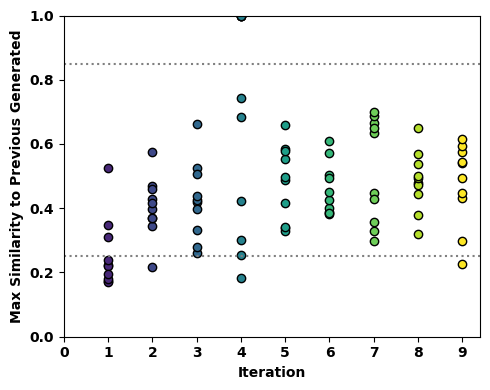

In [88]:
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, number_iter))

plt.figure(figsize=(5, 4))
for i in range(number_iter):  
    for j in range(number_smiles_per_msg):  
        plt.scatter(i, df_iter_MaxSimToPrevGen.iloc[i, j], color=colors[i], edgecolors='black')
plt.axhline(y=tani_thr_RefGen_max, color='grey', linestyle=':')
plt.axhline(y=tani_thr_RefGen_min, color='grey', linestyle=':')

plt.xlabel('Iteration', fontsize=10, fontweight='bold')
plt.ylabel('Max Similarity to Previous Generated', fontsize=10, fontweight='bold')
plt.xticks([i for i in range(number_iter)], fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.ylim(0, 1)

if bool_saved:
    sim_image_path = os.path.join(folderPath_saved, "MaxSim_ToPrevGen.png")
    plt.savefig(sim_image_path, bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

## Complexity

In [89]:
from bottchscore.bottchscore3 import calculate_bottchscore_from_smiles
def calc_bottch_score(smiles):
    m = rdkit.Chem.MolFromSmiles(smiles)
    if m:
        try:
            bottch_score = calculate_bottchscore_from_smiles(
                    smiles,
                    verbose_response=False, 
                    debug_arg=False, 
                    disable_mesomer=False, 
                    automorp_memory_maxsize=3000000
                )
            log_bs = np.log10(bottch_score)
        except:
            bottch_score, log_bs = np.nan, np.nan
    else:
        bottch_score, log_bs = np.nan, np.nan
    return bottch_score, log_bs

df_genSMILESeval[['Bottch', 'Lg_Bottch']] = df_genSMILESeval['Gen_SMILES'].apply(lambda x: pd.Series(calc_bottch_score(x)))
print(df_genSMILESeval.shape)
df_genSMILESeval.head(2)

(100, 12)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,Bottch,Lg_Bottch
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,420.242087,2.62350
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,344.072637,2.53665


In [90]:
def calc_complexity_score(smiles):
    m = Chem.MolFromSmiles(smiles)
    if m:
        complexity_score = Descriptors.BertzCT(m)
        log_cs = np.log10(complexity_score)
    else:
        complexity_score, log_cs = np.nan, np.nan
    return complexity_score, log_cs

df_genSMILESeval[['BertzCT', 'Lg_BertzCT']] = df_genSMILESeval['Gen_SMILES'].apply(lambda x: pd.Series(calc_complexity_score(x)))
print(df_genSMILESeval.shape)
df_genSMILESeval.head(2)

(100, 14)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,Bottch,Lg_Bottch,BertzCT,Lg_BertzCT
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,420.242087,2.62350,757.434108,2.879345
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,344.072637,2.53665,1002.536263,3.001100


## Atom analysis

### Count N and O

In [91]:
def count_N_O(smiles):
    mol = Chem.MolFromSmiles(smiles)
    atom_counts = {'N_count': 0, 'O_count': 0}
    if mol:
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()            
            if symbol == 'N':
                atom_counts['N_count'] += 1
            elif symbol == 'O':
                atom_counts['O_count'] += 1
        
    atom_analysis_Ser = pd.Series(atom_counts)
    
    return atom_analysis_Ser

df_genSMILESeval[['N_count', 'O_count']] = df_genSMILESeval['Gen_SMILES'].apply(count_N_O)
print(df_genSMILESeval.shape)
df_genSMILESeval.head(2)

(100, 16)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,Bottch,Lg_Bottch,BertzCT,Lg_BertzCT,N_count,O_count
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,420.242087,2.62350,757.434108,2.879345,3,7
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,344.072637,2.53665,1002.536263,3.001100,7,0


In [92]:
df_genSMILESeval_valid = df_genSMILESeval[df_genSMILESeval['Target_metal'] != 'Invalid SMILES']
print(df_genSMILESeval_valid.shape)
df_genSMILESeval_valid.head(2)

(100, 16)


,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,Bottch,Lg_Bottch,BertzCT,Lg_BertzCT,N_count,O_count
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,420.242087,2.62350,757.434108,2.879345,3,7
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,344.072637,2.53665,1002.536263,3.001100,7,0


#### Draw N

In [93]:
ser_N_count = df_genSMILESeval_valid['N_count'].value_counts()

max_N_count_in_bar = 13
x_bar = [x for x in range(0, max_N_count_in_bar)]
ser_N_count_reindex = ser_N_count.reindex(x_bar, fill_value=0)
ser_N_count_reindex

N_count
0      0
1      1
2     18
3     29
4     30
5     15
6      6
7      1
8      0
9      0
10     0
11     0
12     0
Name: count, dtype: int64

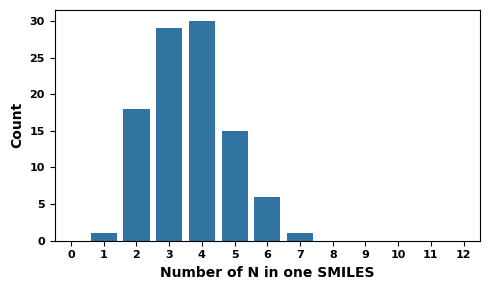

In [94]:
plt.figure(figsize=(5, 3))
sns.barplot(x=x_bar, y=ser_N_count_reindex)

plt.xlabel('Number of N in one SMILES', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.xticks(fontsize=8, fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')

if bool_saved:
    NumN_his_image_path = os.path.join(folderPath_saved, "NumN_bar.png")
    plt.savefig(NumN_his_image_path, bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

#### Draw O

In [95]:
ser_O_count = df_genSMILESeval_valid['O_count'].value_counts()

max_O_count_in_bar = 13
x_bar_forO = [x for x in range(0, max_O_count_in_bar)]
ser_O_count_reindex = ser_O_count.reindex(x_bar, fill_value=0)
ser_O_count_reindex

O_count
0      1
1      0
2     12
3     20
4     22
5     21
6     12
7      6
8      5
9      1
10     0
11     0
12     0
Name: count, dtype: int64

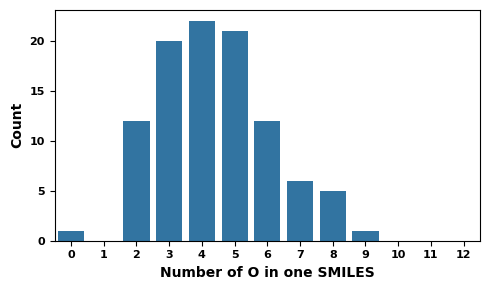

In [96]:
plt.figure(figsize=(5, 3))
sns.barplot(x=x_bar_forO, y=ser_O_count_reindex)

plt.xlabel('Number of O in one SMILES', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.xticks(fontsize=8, fontweight='bold')
plt.yticks(fontsize=8, fontweight='bold')

if bool_saved:
    imagePath_NumO_bar = os.path.join(folderPath_saved, "NumO_bar.png")
    plt.savefig(imagePath_NumO_bar, bbox_inches='tight', dpi=300)
    
plt.tight_layout()
plt.show()

### Count N from 4 to 8

In [97]:
def determine_N_4to8(smiles):
    mol = Chem.MolFromSmiles(smiles)
    dic_atom_counts = {'N_count': 0}
    bool_value = False
    if mol:
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()
            if symbol == 'N':
                dic_atom_counts['N_count'] += 1
    else:
        bool_value = "Invalid SMILES"
        
    if 4 <= dic_atom_counts['N_count'] <= 8:
        bool_value = True
    
    return bool_value

df_genSMILESeval['N_4to8'] = df_genSMILESeval['Gen_SMILES'].apply(determine_N_4to8)
df_genSMILESeval.head(2)

,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,Bottch,Lg_Bottch,BertzCT,Lg_BertzCT,N_count,O_count,N_4to8
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,420.242087,2.62350,757.434108,2.879345,3,7,False
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,344.072637,2.53665,1002.536263,3.001100,7,0,True


### Contain O and N

In [98]:
def determine_NandO(smiles):
    mol = Chem.MolFromSmiles(smiles)
    dic_atom_counts = {'N_count': 0, 'O_count': 0}
    bool_value = False
    if mol:
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()
            if symbol == 'N':
                dic_atom_counts['N_count'] += 1
            elif symbol == 'O':
                dic_atom_counts['O_count'] += 1
    else:
        bool_value = "Invalid SMILES"
     
    if dic_atom_counts['N_count'] >= 1 and dic_atom_counts['O_count'] >= 1:
        bool_value = True
    
    return bool_value

df_genSMILESeval['Contain_NandO'] = df_genSMILESeval['Gen_SMILES'].apply(determine_NandO)
df_genSMILESeval.head(2)

,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,Bottch,Lg_Bottch,BertzCT,Lg_BertzCT,N_count,O_count,N_4to8,Contain_NandO
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,420.242087,2.62350,757.434108,2.879345,3,7,False,True
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,344.072637,2.53665,1002.536263,3.001100,7,0,True,False


In [99]:
def determine_bipyridine(smiles):
    bool_value = False
    mol = Chem.MolFromSmiles(smiles) if smiles else None
    
    if mol is None:
        return ['Invalid SMILES'], 'Invalid SMILES'
    bipyridine_pattern = Chem.MolFromSmarts('[c]1[c][c][n;H0][c]([c]1)[c]1[c][c][c][c][n;H0]1')
    bool_value = mol.HasSubstructMatch(bipyridine_pattern)

    return bool_value

df_genSMILESeval['Contain_bypyridine'] = df_genSMILESeval['Gen_SMILES'].apply(determine_bipyridine)
df_genSMILESeval.head(2)

,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,Bottch,Lg_Bottch,BertzCT,Lg_BertzCT,N_count,O_count,N_4to8,Contain_NandO,Contain_bypyridine
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,420.242087,2.62350,757.434108,2.879345,3,7,False,True,False
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,344.072637,2.53665,1002.536263,3.001100,7,0,True,False,False


## Core SMARTS

In [100]:
N_SMARTS = {'pyridine':'[c]1[c][c][n][c][c]1',
            'bipyridine':'[c]1[c][c][n;H0][c]([c]1)[c]1[c][c][c][c][n;H0]1',
            'terpyridine':'[c]1[c][c][n;H0][c]([c]1)-[c]1[n;H0][c]([c][c][c]1)-[c]1[c][c][c][c][n;H0]1',
            'pyridazine':'[c]1[c][n][n][c][c]1',
            'pyrimidine':'[c]1[c][n][c][n][c]1',
            'imidazole':'[#6]1[#6][#7X3][#6][#7X2]1',
            'pyrazine':'[c]1[c][n][c][c][n]1',
            'pyrazole':'[c]1[c][nX2][nX3][c]1',
            'triazole':'[#6]1[#6][#7][#7][#7]1',
            's_triazole':'[#6]1[#7][#6][#7][#7]1',
            'triazine':'[c]1[c][n][n][c][n]1',
            's_triazine':'[c]1[n][c][n][c][n]1',
            'tetrazole':'[#6]1[#7][#7][#7][#7]1',
            's_tetrazine':'[c]1[n][n][c][n][n]1',
            'bistriazinylpyridine':'[c]1[c][c]([n;H0][c]([c]1)-[c]1[n][c][c][n][n;H0]1)-[c]1[n][c][c][n][n;H0]1',
            'bistriazinyl_bipyridine':'[c]1[c][c]([c]2[c][c][c][c]([c]3[n][c][c][n][n]3)[n]2)[n][c]([c]2[n][c][c][n][n]2)[c]1',
            'n_heterocycle':'[#7&R][#6][#6][#7&R]',
            'triethylamine':'[C][CH2][N]([CH2][C])[CH2][C]',
            'n_ring':'[#6]1[#7X2][#6][#7][#6][#7]1',
            'n_double':'[#6][#6]=[#7][#6][#6]'}  

O_SMARTS = {'organophosphorous':'[#16,#8]=[#15]([#8,#6,#16])([#8,#6,#16])[#8,#6,#16,#7]',
            'diglycolamide':'[#7][C](=O)[C][O][C][C](=O)[#7]',
            'amide':'[#7][#6](=O)[#6]',
            'pyridine_N_oxide':'[c]1[c][c][n+]([c][c]1)-[#8-]',
            'thiophene':'[c]1[c][#16][c][c]1',
            'carboxylic':'[#8;X1]=[#6;X3]-[#8;H0,H1]',
            'hydroxypyranone':'[c]1[c][#8][c][c]([c]1=[#8;H0])-[#8;H1]',
            'ether':'[C]-[O]-[C]',
            'ether_ring':'[#8&R][#6][#6][#8&R]',
            'ketone':'[#6][#6]([#6])=[#8X1]',
            'pyran':'[#6X3]1[#6X3][#8X2][#6X3][#6X3][#6]1',
            'furan':'[#6X3]1[#6X3][#6X3][#8X2][#6X3]1',
            'carbamide':'[#7][#6](=[#8])[#7]',
            'thioketone':'[#16]=[#6](-[#8,#6,#7])-[#8,#6,#7]'}

In [101]:
N_PATTERNS = {name: Chem.MolFromSmarts(s) for name, s in N_SMARTS.items()}
O_PATTERNS = {name: Chem.MolFromSmarts(s) for name, s in O_SMARTS.items()}

def find_substruc(smiles):
    mol = Chem.MolFromSmiles(smiles) if smiles else None
    if mol is None:
        return ['Invalid SMILES'], 'Invalid SMILES'

    matched_N = [name for name, patt in N_PATTERNS.items() if patt and mol.HasSubstructMatch(patt)]
    matched_O = [name for name, patt in O_PATTERNS.items() if patt and mol.HasSubstructMatch(patt)]

    all_matches = matched_N + matched_O
    str_all_matches = ", ".join(all_matches)

    if not matched_N and not matched_O:
        donor_type = 'No N and O donor'
    elif matched_N and matched_O:
        donor_type = 'Mixed N O donor'
    elif matched_N:
        donor_type = 'N donor'
    else:
        donor_type = 'O donor'

    return str_all_matches, donor_type

df_genSMILESeval[['Substructures', 'Donor_type']] = df_genSMILESeval['Gen_SMILES'].apply(lambda s: pd.Series(find_substruc(s)))

df_genSMILESeval.head(2)

,Gen_SMILES,Target_metal,Other_metal,Source,Similarity_to_Experimental,Similarity_to_Generated,LogP,LogP_value,MaxSim_ToExp_value,MaxSim_ToPrevGen_value,...,Lg_Bottch,BertzCT,Lg_BertzCT,N_count,O_count,N_4to8,Contain_NandO,Contain_bypyridine,Substructures,Donor_type
0,CCCCCCCCN(CCCCCCCC)C(=O)COCC(=O)NCCOC(=O)COCC(...,ORGANIC,ORGANIC,LLM generated,MEDIUM,NaN,ORGANIC,8.7782,0.666667,NaN,...,2.62350,757.434108,2.879345,3,7,False,True,False,"diglycolamide, amide, carboxylic, ether",O donor
1,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,ORGANIC,AQUEOUS,LLM generated,MEDIUM,NaN,ORGANIC,5.2874,0.313253,NaN,...,2.53665,1002.536263,3.001100,7,0,True,False,False,"pyridine, s_triazole, triazine, n_heterocycle",N donor


## Save Processed Eval Table

In [102]:
if bool_saved:
    filePath_genSMILESeval_proc = os.path.join(folderPath_saved, "genSMILESeval_proc.xlsx")
    df_genSMILESeval.to_excel(filePath_genSMILESeval_proc, index=False)

## Clean conditions

In [103]:
fileName_genSMILESconditions = "genSMILESconditions.xlsx"
filePath_genSMILESconditions = os.path.join(folderPath_results, fileName_genSMILESconditions)

df_SMILESconditions = pd.read_excel(filePath_genSMILESconditions)
print(df_SMILESconditions.shape)
df_SMILESconditions.head(1)

(1134, 32)


,Extractant_conc_M,Volume_fraction_A,Volume_fraction_B,Molar_mass(g/mol)_A,Log_P_A,Boiling_point(K)_A,Melting_point(K)_A,Density(g/mL)_A,Molar_mass(g/mol)_B,Log_P_B,...,Second_IE_kJ/mol,Third_IE_kJ/mol,Matallic_radius_nm,Pauling_EN,Ionic_radius_nm,Oxidation_state,New_extractants_SMILES,Pred_class,Solvent_A_name,Metal_name
0,0.05,1,0,170.34,4.9272,489.427778,263.538889,0.7487,0,0,...,1130.0,2090.0,0.173,1.3,0.1115,3,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,2,n-dodecane,Am(III)


In [104]:
delete_cols = [
        "Molar_mass(g/mol)_A",
        "Log_P_A",
        "Boiling_point(K)_A",
        "Melting_point(K)_A",
        "Density(g/mL)_A",
        "Molar_mass(g/mol)_B",
        "Log_P_B",
        "Boiling_point(K)_B",
        "Melting_point(K)_B",
        "Density(g/mL)_B",
        "Atomic_number",
        "Melting_point_K",
        "Boiling_point_K",
        "Density_g/cm3",
        "First_IE_kJ/mol",
        "Second_IE_kJ/mol",
        "Third_IE_kJ/mol",
        "Matallic_radius_nm",
        "Pauling_EN",
        "Ionic_radius_nm",
        "Oxidation_state",
        "Dipole_moment_D",
    ]

df_SMILESconditions.drop(delete_cols, axis=1, inplace=True)
df_SMILESconditions.head(2)

,Extractant_conc_M,Volume_fraction_A,Volume_fraction_B,Acid_conc_M,Temperature_K,Log_metal_conc_mM,New_extractants_SMILES,Pred_class,Solvent_A_name,Metal_name
0,0.05,1,0,0.5,298,-8.00000,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,2,n-dodecane,Am(III)
1,0.05,1,0,0.5,298,-1.30103,CC(C)Cc1nc(-c2cc(C(C)C)cc(-c3nnc(C(C)C)c(C(C)C...,0,n-dodecane,Eu(III)


In [105]:
if bool_saved:
    filePath_genSMILES_conditions_cleaned = os.path.join(folderPath_saved, "genSMILES_conditions_cleaned.xlsx")
    df_SMILESconditions.to_excel(filePath_genSMILES_conditions_cleaned, index=False)